In [1]:
# --- General Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# --- Scikit-learn Imports ---
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

# --- AutoML Imports ---
from flaml import AutoML

# --- GNN Imports ---
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Ignore some common warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

print("--- Starting Data Preprocessing ---")

# --- Step 1: Define File Paths ---
main_data_path = '/Users/adithyamadduri/Downloads/all_chr_merged.parquet'
gwas_catalog_path = '/Users/adithyamadduri/Downloads/MONDO_0004975_associations_export.tsv'
string_links_path = '/Users/adithyamadduri/Downloads/9606.protein.links.v12.0.txt'
string_info_path = '/Users/adithyamadduri/Downloads/9606.protein.info.v12.0.txt'

# --- Step 2: Load Raw Data and Map SNPs to Genes ---
print("--- Step 2: Loading Data and Mapping SNPs to Genes ---")
df = pd.read_parquet(main_data_path)
gwas_df = pd.read_csv(gwas_catalog_path, sep='\t')

gwas_df['riskAllele_cleaned'] = gwas_df['riskAllele'].str.split('-').str[0].str.strip()
gwas_df['first_gene'] = gwas_df['mappedGenes'].str.split(',').str[0].str.strip()
rs_map = gwas_df.dropna(subset=['riskAllele_cleaned', 'first_gene']).set_index('riskAllele_cleaned')['first_gene'].to_dict()

df.columns = [col.strip() for col in df.columns]
snp_cols = [col for col in df.columns if col.startswith('rs') or col.startswith('chr')]
all_mapped_snps = {snp_col: rs_map.get(snp_col.split('_')[0]) for snp_col in snp_cols if rs_map.get(snp_col.split('_')[0])}

# --- Step 3: Perform SNP Quality Control ---
print("\n--- Step 3: Performing SNP Quality Control ---")
snps_to_map = list(all_mapped_snps.keys())
maf = df[snps_to_map].apply(lambda x: (2*x.eq(2).sum() + x.eq(1).sum()) / (2*x.notna().sum()), axis=0)
snps_to_remove_maf = maf[maf < 0.01].index.tolist()
missing_rates = df[snps_to_map].isna().mean()
snps_to_remove_callrate = missing_rates[missing_rates > 0.05].index.tolist()
all_snps_to_remove = set(snps_to_remove_maf + snps_to_remove_callrate)

all_mapped_snps_qc = {snp: gene for snp, gene in all_mapped_snps.items() if snp not in all_snps_to_remove}
df_qc = df.drop(columns=list(all_snps_to_remove))
snp_cols_qc = list(all_mapped_snps_qc.keys())
print(f"Retained {len(snp_cols_qc)} SNPs after QC.")

# --- Step 4: Assign Labels ---
print("\n--- Step 4: Assigning Labels ---")
df_qc['age_death'] = pd.to_numeric(df_qc['age_death'].astype(str).replace('90+', '90', regex=False), errors='coerce')
# The explicit class definitions you provided
conditions = [
    (df_qc['ceradsc'].isin([1, 2])) & (df_qc['cogdx'].isin([4, 5])),
    (df_qc['ceradsc'].isin([1, 2])) & ~(df_qc['cogdx'].isin([4, 5])),
    ~(df_qc['ceradsc'].isin([1, 2])) & (df_qc['cogdx'].isin([4, 5])),
    ~(df_qc['ceradsc'].isin([1, 2])) & ~(df_qc['cogdx'].isin([4, 5]))
]
choices = ['Typical AD', 'Resilient', 'Symptomatic Non-AD', 'Healthy Control']
df_qc['patient_group'] = np.select(conditions, choices, default='Unknown')
df_qc = df_qc[df_qc['patient_group'] != 'Unknown'] # Remove any unclassified patients

print("Patient Group Counts:")
print(df_qc['patient_group'].value_counts())

# --- Step 5: Create a gene-summed feature matrix with demographic covariates ---
print("\n--- Step 5: Creating Gene-Summed Feature Matrix ---")

# Define demographic and binary variables (reusing your structure)
numeric_features = ['age_death', 'educ']
categorical_features = ['apoe_genotype']
binary_features = ['msex']
snp_features = snp_cols_qc

# Extract necessary data
feature_df = df_qc[['projid'] + numeric_features + categorical_features + binary_features + snp_features].copy()

# Impute missing numeric values ONLY (no scaling)
imputer_num = SimpleImputer(strategy='median')
feature_df[numeric_features] = imputer_num.fit_transform(feature_df[numeric_features])

# --- NO SNP IMPUTATION ---
# Keep SNPs as-is (may contain NaN); round only observed values to {0,1,2}
snp_block = feature_df[snp_features].astype(float)
mask = ~snp_block.isna()
rounded = np.empty_like(snp_block.values)
rounded[:] = np.nan
rounded[mask.values] = np.rint(snp_block.values[mask.values])
snp_block = pd.DataFrame(rounded, columns=snp_features, index=feature_df.index)
feature_df[snp_features] = snp_block

feature_df[binary_features] = feature_df[binary_features].astype(int)

# --- Step 5a: Create gene-summed dosage features (no scaling) ---
print("Summing SNPs into gene-level features...")

gene_to_snps = defaultdict(list)
for snp, gene in all_mapped_snps_qc.items():
    gene_to_snps[gene].append(snp)

gene_dosage_df = pd.DataFrame(index=feature_df.index)
for gene, snp_list in gene_to_snps.items():
    vals = feature_df[snp_list].to_numpy(dtype=float)
    # Sum across SNPs, ignoring NaNs
    gene_sum = np.nansum(vals, axis=1)
    # If ALL SNPs for a sample are NaN, keep NaN (avoid fabricating zeros)
    all_missing = np.isnan(vals).all(axis=1)
    gene_sum[all_missing] = np.nan
    gene_dosage_df[gene] = gene_sum  # keep float so NaNs are preserved

# One-hot encode APOE genotype (keep as before)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
apoe_encoded = ohe.fit_transform(feature_df[categorical_features])
apoe_df = pd.DataFrame(apoe_encoded, columns=ohe.get_feature_names_out(), index=feature_df.index)

# Final gene-based feature matrix (raw age/educ, raw binary, APOE OHE, gene sums with NaNs)
X_gene_based = pd.concat([
    feature_df[numeric_features + binary_features].reset_index(drop=True),
    apoe_df.reset_index(drop=True),
    gene_dosage_df.reset_index(drop=True)
], axis=1)

X_gene_based.columns = X_gene_based.columns.astype(str)
print(f"Created gene-summed + demographic feature matrix with shape: {X_gene_based.shape}")

print(f"Created gene-summed + demographic feature matrix with shape: {X_gene_based.shape}")


# --- Step 6: Encode Labels and Create Train-Test Split ---
print("\n--- Step 6: Encoding Labels and Creating Train-Test Split ---")
y_labels = df_qc['patient_group'].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)

# Using StratifiedShuffleSplit for a single 70-30 split

y_strat = df_qc['patient_group'].astype(str) + "_" + df_qc['msex'].astype(str)


--- Starting Data Preprocessing ---
--- Step 2: Loading Data and Mapping SNPs to Genes ---

--- Step 3: Performing SNP Quality Control ---
Retained 445 SNPs after QC.

--- Step 4: Assigning Labels ---
Patient Group Counts:
patient_group
Healthy Control       353
Typical AD            223
Resilient             179
Symptomatic Non-AD     56
Name: count, dtype: int64

--- Step 5: Creating Gene-Summed Feature Matrix ---
Summing SNPs into gene-level features...
Created gene-summed + demographic feature matrix with shape: (811, 360)
Created gene-summed + demographic feature matrix with shape: (811, 360)

--- Step 6: Encoding Labels and Creating Train-Test Split ---


/var/folders/yr/4bplyc1x1tq4xz4jckbg_8wr0000gn/T/ipykernel_65950/1145937379.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_dosage_df[gene] = gene_sum  # keep float so NaNs are preserved
/var/folders/yr/4bplyc1x1tq4xz4jckbg_8wr0000gn/T/ipykernel_65950/1145937379.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_dosage_df[gene] = gene_sum  # keep float so NaNs are preserved
/var/folders/yr/4bplyc1x1tq4xz4jckbg_8wr0000gn/T/ipykernel_65950/1145937379.py:129: PerformanceWarning: DataFrame is highly fragmented.  T

In [21]:
seeds = [1, 2, 3, 4, 5,]

from collections import defaultdict
rf_auc_by_seed = defaultdict(list)

import os
out_dir = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/RF(Genes+Demo)"
os.makedirs(out_dir, exist_ok=True)

# REPLACE your existing sss+for-header with the two lines below:
for seed in seeds:  
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=seed)
    for train_index, test_index in sss.split(X_gene_based, y_strat):
        X_train, X_test = X_gene_based.iloc[train_index], X_gene_based.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Keep track of patient IDs for GNN mapping
        train_projids = df_qc.iloc[train_index]['projid']
        test_projids = df_qc.iloc[test_index]['projid']


    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print("Label to Class Name mapping:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"{i}: {class_name}")

    from flaml import AutoML
    from sklearn.metrics import accuracy_score, roc_auc_score
    import numpy as np
    import pickle

    

    # =============================================================================
    # SECTION 3b: AutoML with FLAML (ONE-VS-REST) - Random Forest Baseline
    # =============================================================================
    print("\n\n--- Training AutoML Random Forest Baseline (One-vs-Rest) ---")

    rf_results = {}
    rf_objects = {}



    for i, class_name in enumerate(label_encoder.classes_):
        print(f"\n--- RF baseline for class: '{class_name}' vs. Rest ---")
        
        y_train_ovr = (y_train == i).astype(int)
        y_test_ovr  = (y_test  == i).astype(int)

        if np.sum(y_test_ovr) < 1:
            print(f"Skipping class '{class_name}' due to no positive samples in the test set.")
            continue

        automl_rf = AutoML()
        automl_settings_rf = {
            "time_budget": 100,
            "metric": "roc_auc",
            "task": "classification",
            "eval_method": "cv",
            "n_splits": 5,
            "seed": seed,
            "log_file_name": f"flaml_rf_seed{seed}_{class_name.replace(' ', '_')}.log",
            "estimator_list": ["rf"],       # << only RandomForest
            "model_history": False
        }

        automl_rf.fit(
            X_train=X_train,
            y_train=y_train_ovr,
            **automl_settings_rf
        )

        rf_objects[class_name] = automl_rf
        print(f"Best RF model for '{class_name}': {automl_rf.best_estimator}")

        y_proba = automl_rf.predict_proba(X_test)[:, 1]
        y_pred  = automl_rf.predict(X_test)
        acc     = accuracy_score(y_test_ovr, y_pred)
        auc     = roc_auc_score(y_test_ovr, y_proba)

        print(f"Accuracy: {acc:.4f} | ROC AUC: {auc:.4f}")

        roc_df = pd.DataFrame({
            "y_true": y_test_ovr.astype(int),
            "y_score": y_proba.astype(float)
        })
        roc_path = os.path.join(out_dir, f"seed{seed}_{class_name.replace(' ', '_')}.csv")
        roc_df.to_csv(roc_path, index=False)

        rf_auc_by_seed[class_name].append(auc)  # NEW: record per-seed AUC

        rf_results[class_name] = {
            "y_test": y_test_ovr,
            "y_pred_proba": y_proba,
            "roc_auc": auc
        }

    # Save RF results
    with open(f'rf_results_genes_demo_{seed}.pkl', 'wb') as f:
        pickle.dump(rf_results, f)

    print("RF baseline results saved successfully.")


# ---- Summary over seeds (new) ----
import pandas as pd
import numpy as np

rows = []
for cls, aucs in rf_auc_by_seed.items():
    rows.append({
        "Model": "RandomForest",
        "Class": cls,
        "Mean_ROC_AUC": float(np.mean(aucs)),
        "Std_ROC_AUC": float(np.std(aucs)),
        "N_splits": len(aucs)
    })

rf_summary_df = pd.DataFrame(rows)
rf_summary_df.to_csv("rf_results_genes_demo_summary.csv", index=False)
print(rf_summary_df)

Training set shape: (567, 360)
Test set shape: (244, 360)
Label to Class Name mapping:
0: Healthy Control
1: Resilient
2: Symptomatic Non-AD
3: Typical AD


--- Training AutoML Random Forest Baseline (One-vs-Rest) ---

--- RF baseline for class: 'Healthy Control' vs. Rest ---
[flaml.automl.logger: 08-27 20:34:12] {1752} INFO - task = classification
[flaml.automl.logger: 08-27 20:34:12] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 08-27 20:34:12] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 08-27 20:34:12] {1979} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl.logger: 08-27 20:34:12] {2282} INFO - iteration 0, current learner rf
[flaml.automl.logger: 08-27 20:34:12] {2417} INFO - Estimated sufficient time budget=2258s. Estimated necessary time budget=2s.
[flaml.automl.logger: 08-27 20:34:12] {2466} INFO -  at 0.3s,	estimator rf's best error=0.4528,	best estimator rf's best error=0.4528
[flaml.automl.logger: 08-27 20:34:12] {2282} INF

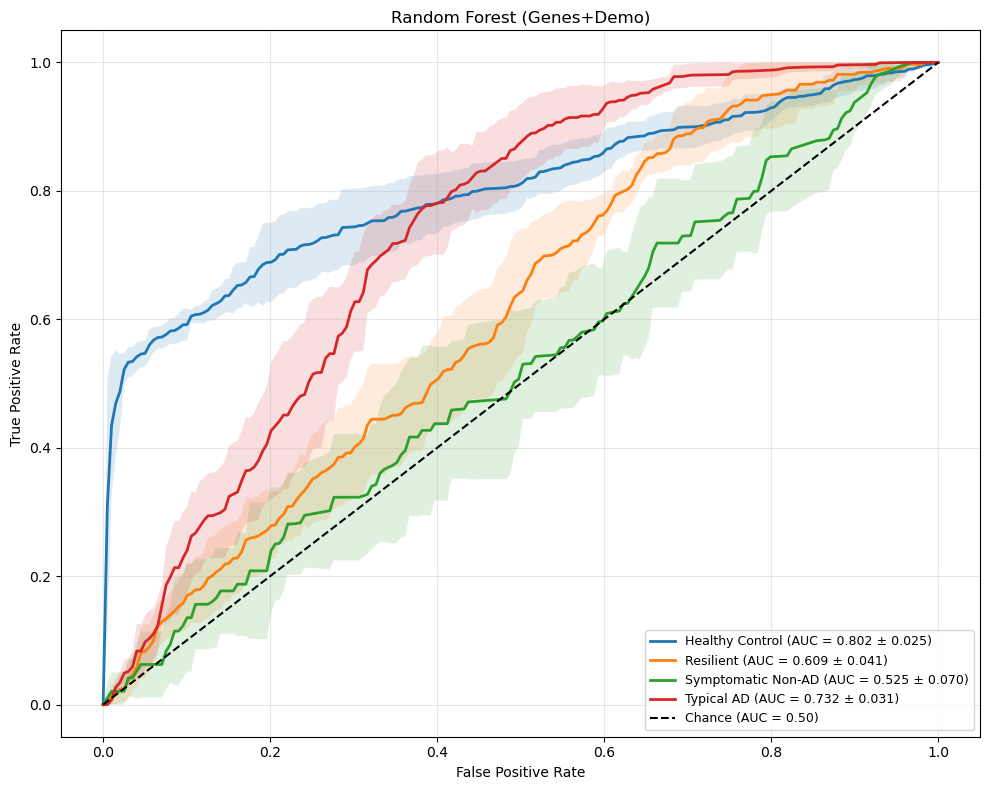

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ---- Mean ROC across seeds from saved CSVs ----
folder = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/RF(Genes+Demo)"
files = glob.glob(os.path.join(folder, "seed*_*.csv"))
assert len(files) > 0, "No per-seed ROC CSVs found in RF(Genes+Demo)."

# Infer class names from filenames (everything after 'seedX_')
def class_from_path(p):
    base = os.path.basename(p)
    return "_".join(base.split("_")[1:]).rsplit(".csv", 1)[0]  # e.g., 'Typical_AD'

class_names = sorted(set(class_from_path(p) for p in files))

fpr_grid = np.linspace(0.0, 1.0, 200)  # common grid for interpolation

plt.figure(figsize=(10, 8))

for cls in class_names:
    cls_files = sorted(glob.glob(os.path.join(folder, f"seed*_{cls}.csv")))
    if not cls_files:
        continue

    tprs_interp, aucs = [], []

    for path in cls_files:
        df = pd.read_csv(path)
        y_true  = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values

        # EXACTLY like your ratios plots: no FPR de-dup
        fpr, tpr, _ = roc_curve(y_true, y_score)

        # Interpolate TPR on common grid (no forcing tpr[-1] = 1.0)
        tpr_i = np.interp(fpr_grid, fpr, tpr)
        tpr_i[0] = 0.0
        tprs_interp.append(tpr_i)

        # AUC on raw fpr/tpr
        aucs.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs_interp, axis=0)
    std_tpr  = np.std(tprs_interp, axis=0)
    mean_auc = float(np.mean(aucs))
    std_auc  = float(np.std(aucs))

    plt.plot(fpr_grid, mean_tpr, lw=2,
             label=f"{cls.replace('_',' ')} (AUC = {mean_auc:.3f} ± {std_auc:.3f})")
    plt.fill_between(fpr_grid,
                     np.clip(mean_tpr - std_tpr, 0, 1),
                     np.clip(mean_tpr + std_tpr, 0, 1),
                     alpha=0.15)

# Chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest (Genes+Demo)')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
seeds = [1, 2, 3, 4, 5,]

from collections import defaultdict
lgbm_auc_by_seed = defaultdict(list)

import os
out_dir = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/LGBM(Genes+Demo)"
os.makedirs(out_dir, exist_ok=True)

from pathlib import Path
def safe_cls(c): return c.replace("+","plus").replace(" ","_").replace("/","-")

# REPLACE your existing sss+for-header with the two lines below:
for seed in seeds:  
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=seed)
    for train_index, test_index in sss.split(X_gene_based, y_strat):
        X_train, X_test = X_gene_based.iloc[train_index], X_gene_based.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Keep track of patient IDs for GNN mapping
        train_projids = df_qc.iloc[train_index]['projid']
        test_projids = df_qc.iloc[test_index]['projid']


    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print("Label to Class Name mapping:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"{i}: {class_name}")

    from flaml import AutoML
    from sklearn.metrics import accuracy_score, roc_auc_score
    import numpy as np
    import pickle

    

    # =============================================================================
    # SECTION 3b: AutoML with FLAML (ONE-VS-REST) - Random Forest Baseline
    # =============================================================================
    print("\n\n--- Training AutoML LGBM (One-vs-Rest) ---")

    lgbm_results = {}
    lgbm_objects = {}



    for i, class_name in enumerate(label_encoder.classes_):
        print(f"\n--- RF baseline for class: '{class_name}' vs. Rest ---")
        
        y_train_ovr = (y_train == i).astype(int)
        y_test_ovr  = (y_test  == i).astype(int)

        if np.sum(y_test_ovr) < 1:
            print(f"Skipping class '{class_name}' due to no positive samples in the test set.")
            continue

        automl_lgbm = AutoML()
        automl_settings_lgbm = {
            "time_budget": 100,
            "metric": "roc_auc",
            "task": "classification",
            "eval_method": "cv",
            "n_splits": 5,
            "seed": seed,
            "log_file_name": f"flaml_lgbm_seed{seed}_{class_name.replace(' ', '_')}.log",
            "estimator_list": ["lgbm"],       # << only RandomForest
            "model_history": False
        }

        automl_lgbm.fit(
            X_train=X_train,
            y_train=y_train_ovr,
            **automl_settings_lgbm
        )

        lgbm_objects[class_name] = automl_lgbm
        print(f"Best LGBM model for '{class_name}': {automl_lgbm.best_estimator}")

        y_proba = automl_lgbm.predict_proba(X_test)[:, 1]
        y_pred  = automl_lgbm.predict(X_test)
        acc     = accuracy_score(y_test_ovr, y_pred)
        auc     = roc_auc_score(y_test_ovr, y_proba)

        print(f"Accuracy: {acc:.4f} | ROC AUC: {auc:.4f}")

        roc_df = pd.DataFrame({
            "y_true": y_test_ovr.astype(int),
            "y_score": y_proba.astype(float)
        })
        roc_path = os.path.join(out_dir, f"seed{seed}_{class_name.replace(' ', '_')}.csv")
        roc_df.to_csv(roc_path, index=False)

        lgbm_auc_by_seed[class_name].append(auc)  # NEW: record per-seed AUC

        lgbm_results[class_name] = {
            "y_test": y_test_ovr,
            "y_pred_proba": y_proba,
            "roc_auc": auc
        }
    
        pkl_path = os.path.join(out_dir, f"seed{seed}_{safe_cls(class_name)}_automl.pkl")
        with open(pkl_path, "wb") as f:
            pickle.dump(automl_lgbm, f)

    # # Save LGBM results
    # with open(f'lgbm_results_genes_demo_{seed}.pkl', 'wb') as f:
    #     pickle.dump(lgbm_results, f)



    print("LGBM baseline results saved successfully.")


# ---- Summary over seeds (new) ----
import pandas as pd
import numpy as np

rows = []
for cls, aucs in lgbm_auc_by_seed.items():
    rows.append({
        "Model": "LGBM",
        "Class": cls,
        "Mean_ROC_AUC": float(np.mean(aucs)),
        "Std_ROC_AUC": float(np.std(aucs)),
        "N_splits": len(aucs)
    })

lgbm_summary_df = pd.DataFrame(rows)
lgbm_summary_df.to_csv("lgbm_results_genes_demo_summary.csv", index=False)
print(lgbm_summary_df)

Training set shape: (567, 360)
Test set shape: (244, 360)
Label to Class Name mapping:
0: Healthy Control
1: Resilient
2: Symptomatic Non-AD
3: Typical AD


--- Training AutoML LGBM (One-vs-Rest) ---

--- RF baseline for class: 'Healthy Control' vs. Rest ---
[flaml.automl.logger: 09-04 17:44:05] {1752} INFO - task = classification
[flaml.automl.logger: 09-04 17:44:05] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 09-04 17:44:05] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 09-04 17:44:05] {1979} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 09-04 17:44:05] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 09-04 17:44:05] {2417} INFO - Estimated sufficient time budget=897s. Estimated necessary time budget=1s.
[flaml.automl.logger: 09-04 17:44:05] {2466} INFO -  at 0.2s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 09-04 17:44:05] {2282} INFO - iterati

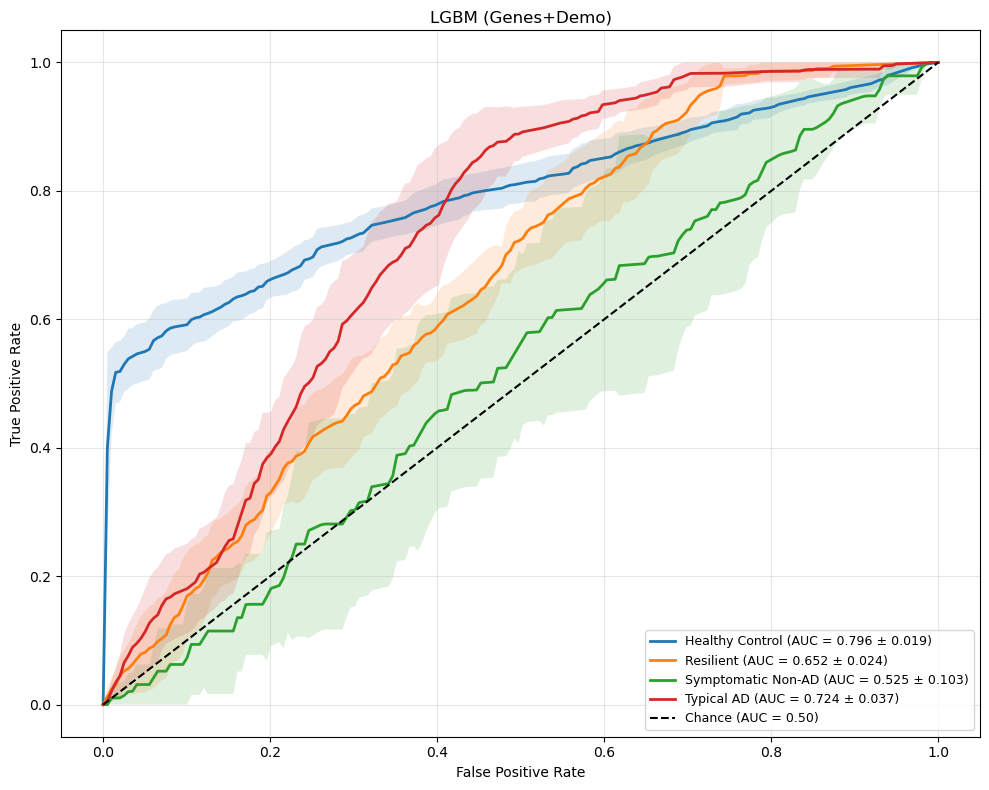

In [2]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ---- Mean ROC across seeds from saved CSVs ----
folder = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/LGBM(Genes+Demo)"
files = glob.glob(os.path.join(folder, "seed*_*.csv"))
assert len(files) > 0, "No per-seed ROC CSVs found in LGBM(Genes+Demo)."

# Infer class names from filenames (everything after 'seedX_')
def class_from_path(p):
    base = os.path.basename(p)
    return "_".join(base.split("_")[1:]).rsplit(".csv", 1)[0]  # e.g., 'Typical_AD'

class_names = sorted(set(class_from_path(p) for p in files))

fpr_grid = np.linspace(0.0, 1.0, 200)  # common grid for interpolation

plt.figure(figsize=(10, 8))

for cls in class_names:
    cls_files = sorted(glob.glob(os.path.join(folder, f"seed*_{cls}.csv")))
    if not cls_files:
        continue

    tprs_interp, aucs = [], []

    for path in cls_files:
        df = pd.read_csv(path)
        y_true  = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values

        # EXACTLY like your ratios plots: no FPR de-dup, no forcing tpr[-1]=1.0
        fpr, tpr, _ = roc_curve(y_true, y_score)

        # Interpolate TPR on common grid (just set start to 0.0 like your ratios script)
        tpr_i = np.interp(fpr_grid, fpr, tpr)
        tpr_i[0] = 0.0
        tprs_interp.append(tpr_i)

        # AUC on raw fpr/tpr
        aucs.append(auc(fpr, tpr))

    if not tprs_interp:
        continue

    mean_tpr = np.mean(tprs_interp, axis=0)
    std_tpr  = np.std(tprs_interp, axis=0)
    mean_auc = float(np.mean(aucs))
    std_auc  = float(np.std(aucs))

    plt.plot(
        fpr_grid, mean_tpr, lw=2,
        label=f"{cls.replace('_',' ')} (AUC = {mean_auc:.3f} ± {std_auc:.3f})"
    )
    plt.fill_between(
        fpr_grid,
        np.clip(mean_tpr - std_tpr, 0, 1),
        np.clip(mean_tpr + std_tpr, 0, 1),
        alpha=0.15
    )

# Chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGBM (Genes+Demo)')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()